### Hipótese

ZCTAs com muitos laboratórios podem indicar saturação, baixa receita, do mercado.

---

In [1]:
# Importando bibliotecas
import warnings
import pandas as pd
import numpy as np
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
# Carregando os data sets relacionados
transactional_data = pd.read_csv('../../../data/processed/transactional_data_clean.csv')
geocode_data = pd.read_csv('../../../data/processed/geocode_data_clean.csv')

In [3]:
# 1. Contagem de laboratórios existem por ZCTA
labs_por_zcta = geocode_data.groupby('zipcode')['lab_id'].count().reset_index()
labs_por_zcta.columns = ['zipcode', 'num_labs']

labs_por_zcta.describe()

,zipcode,num_labs
count,105.000000,105.000000
mean,44393.609524,1.123810
std,36386.080150,0.384689
min,1605.000000,1.000000
25%,13421.000000,1.000000
50%,30096.000000,1.000000
75%,94520.000000,1.000000
max,98383.000000,3.000000


In [4]:
# 2. Juntando transações com geocode para obter o ZCTA de cada transação
transactional_with_geocode = pd.merge(transactional_data, geocode_data[['lab_id', 'zipcode']], on='lab_id', how='inner')

transactional_with_geocode.head()

,patient_id,gender,dateofbirth,dateofservice,service_id,lab_id,cod_item,testing_cost,zipcode
0,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70003237,9.0,94565
1,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000638,13.0,94565
2,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70001597,49.0,94565
3,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000103,11.0,94565
4,10210830256-BIO003,F,1976-08-01 00:00:00,2019-01-07,571904533475-38,L133,70000224,10.0,94565


In [5]:
# 3. Calcular receita total por ZCTA
revenue_per_zcta = transactional_with_geocode.groupby('zipcode')['testing_cost'].sum().reset_index()
revenue_per_zcta.columns = ['zipcode', 'receita_total']

revenue_per_zcta.describe()

,zipcode,receita_total
count,104.000000,1.040000e+02
mean,43911.567308,1.149745e+06
std,36223.825191,1.824577e+06
min,1605.000000,1.516200e+04
25%,13419.000000,2.270813e+05
50%,30090.000000,4.312033e+05
75%,94514.750000,1.007757e+06
max,98383.000000,9.711866e+06


In [6]:
# 4. Juntar todas as informações para análise
num_labs_zcta = pd.merge(labs_por_zcta, revenue_per_zcta, on='zipcode', how='outer')

In [7]:
# 5. Calculando receita média por laboratório
num_labs_zcta['receita_por_lab'] = num_labs_zcta['receita_total'] / np.where(num_labs_zcta['num_labs'] > 0, num_labs_zcta['num_labs'], 1)

In [8]:
# Vizualizando resultado
num_labs_zcta

,zipcode,num_labs,receita_total,receita_por_lab
0,1605,1,323954.36,323954.36
1,1606,1,313512.08,313512.08
2,1701,1,930395.16,930395.16
3,1702,1,505300.80,505300.80
4,1840,1,1263382.62,1263382.62
...,...,...,...,...
100,98122,1,813772.72,813772.72
101,98133,1,2486118.80,2486118.80
102,98148,2,289041.00,144520.50
103,98370,1,377874.80,377874.80


In [9]:
# 6. Realizand o teste ANOVA para verificar se a receita média por laboratório é diferente entre os grupos de ZCTA
grups_for_anova = {
    num_lab: num_labs_zcta[num_labs_zcta['num_labs'] == num_lab]['receita_por_lab'].dropna().values
    for num_lab in num_labs_zcta['num_labs'].unique()
}

f_statistic, p_value = stats.f_oneway(grups_for_anova[1], grups_for_anova[2], grups_for_anova[3])

print(f'p_value: {p_value}')

p_value: 0.6303109441363461


Como o p-value (0.6303) é maior ou igual ao nível de significância (0.05), não rejeitamos a hipótese nula.
Isso indica que não há evidências suficientes de diferença na receita média por laboratório
relacionadas à quantidade de laboratórios em um mesmo ZCTA.

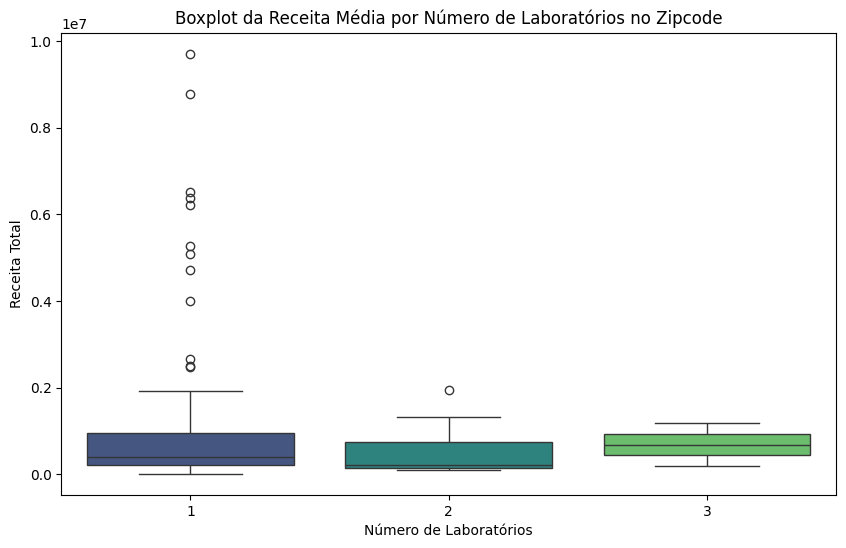

In [10]:
# Visuazalizando a distribuição da receita média por número de laboratórios por ZCTA
filtered_data = num_labs_zcta[num_labs_zcta['num_labs'].isin(num_labs_zcta['num_labs'].unique())]

plt.figure(figsize=(10, 6))
sns.boxplot(data=filtered_data, x='num_labs', y='receita_por_lab', palette='viridis')
plt.title('Boxplot da Receita Média por Número de Laboratórios no Zipcode')
plt.xlabel('Número de Laboratórios')
plt.ylabel('Receita Total')
plt.show()

---

### Conclusão
A hipótese inicial proposta foi rejeitada pela análise estatística ANOVA realizada. Os resultados obtidos foram os seguintes:

- Teste ANOVA: não apresentou diferença estatisticamente significativa na receita média por laboratório em função da quantidade de laboratórios por ZCTA, com p-value igual a 0.6303.

Este resultado indica que não há evidências suficientes para afirmar que um maior número de laboratórios em uma mesma região (ZCTA) esteja relacionado à saturação do mercado e consequente redução da receita média dos laboratórios, como inicialmente suposto.

O gráfico Boxplot da Receita Média por Número de Laboratórios reforça visualmente esses resultados, demonstrando uma ampla sobreposição das faixas de receita entre os grupos (1, 2 e 3 laboratórios por ZCTA), apesar de existirem alguns outliers especialmente no grupo com apenas um laboratório.